In [50]:
import pandas as pd
import numpy as np
import requests
import os
import io
from zipfile import ZipFile
import geopandas as gpd

In [9]:
parent_path = r'C:\Users\01150208\OneDrive - Politechnika Warszawska\Pliki_Kuby\Studia\III_ROK\PAG\PAG_II\projekt1'
directory = 'Dane'
path = os.path.join(parent_path, directory)
if not os.path.exists(path):
    os.mkdir(path)
    print("Directory '%s' created" % directory)

In [10]:
year = '2020'
month = '05'
url = f'https://dane.imgw.pl/datastore/getfiledown/Arch/Telemetria/Meteo/{year}/Meteo_{year}-{month}.zip'
r = requests.get(url, allow_redirects=True)
if r:
    print(r.status_code)

200


In [11]:
meteo_dir = f'Meteo_{year}-{month}'
data_path = os.path.join(path, meteo_dir)
if not os.path.exists(data_path):
    os.mkdir(data_path)
with ZipFile(io.BytesIO(r.content), 'r') as zip:
    zip.extractall(path=data_path)

In [12]:
code = 'B00300S'
for file in os.listdir(data_path):
    if file.startswith(code):
        df = pd.read_csv(os.path.join(data_path, file), header=None, delimiter=';', usecols=[0,1,2,3])
df.head()

,0,1,2,3
0,249190890,B00300S,2020-05-01 00:10,9
1,249190890,B00300S,2020-05-01 00:20,"9,1"
2,249190890,B00300S,2020-05-01 00:30,9
3,249190890,B00300S,2020-05-01 00:40,9
4,249190890,B00300S,2020-05-01 00:50,9


In [13]:
df.rename(columns={0:"KodSH", 1:"ParametrSH", 2:'Data', 3:"Wartość"}, inplace=True)

In [14]:
df.head()

,KodSH,ParametrSH,Data,Wartość
0,249190890,B00300S,2020-05-01 00:10,9
1,249190890,B00300S,2020-05-01 00:20,"9,1"
2,249190890,B00300S,2020-05-01 00:30,9
3,249190890,B00300S,2020-05-01 00:40,9
4,249190890,B00300S,2020-05-01 00:50,9


In [42]:
start_day = df[df['Data'].str.contains('2020-05-01')]

In [45]:
start_day['Wartość'] = start_day['Wartość'].str.replace(',','.')
start_day['Wartość'] = start_day['Wartość'].astype(float)

C:\Users\01150208\AppData\Local\Temp/ipykernel_1172/3559415075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_day['Wartość'] = start_day['Wartość'].str.replace(',','.')
C:\Users\01150208\AppData\Local\Temp/ipykernel_1172/3559415075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_day['Wartość'] = start_day['Wartość'].astype(float)


In [52]:
start_day.groupby('KodSH').mean()

,Wartość
KodSH,
249180010,11.181944
249180160,11.497708
249180210,9.537847
249180230,9.935417
249180260,8.925694
...,...
354180135,10.252083
354180155,10.777083
354190160,9.740972


In [48]:
import datetime
from astral.sun import sun
from astral import LocationInfo
city = LocationInfo("Warsaw", "Poland", "Europe/Warsaw", 52.0, 21.0)
s = sun(city.observer, date=datetime.date(2021, 10, 22))
print((
    f'Dawn:    {s["dawn"]}\n'
    f'Sunrise: {s["sunrise"]}\n'
    f'Noon:    {s["noon"]}\n'
    f'Sunset:  {s["sunset"]}\n'
    f'Dusk:    {s["dusk"]}\n'
))

Dawn:    2021-10-22 04:38:05.746104+00:00
Sunrise: 2021-10-22 05:13:23.395679+00:00
Noon:    2021-10-22 10:20:28+00:00
Sunset:  2021-10-22 15:26:38.110085+00:00
Dusk:    2021-10-22 16:01:51.631447+00:00



In [56]:
shape_path = r"C:\Users\01150208\OneDrive - Politechnika Warszawska\Pliki_Kuby\Studia\III_ROK\PAG\PAG_II\projekt1\Dane\shapefile"
meteo_station = gpd.read_file(os.path.join(shape_path, 'effacility.geojson'))
polska = gpd.read_file(os.path.join(shape_path, 'polska.shp'))
woj = gpd.read_file(os.path.join(shape_path, 'woj.shp'))
powiaty = gpd.read_file(os.path.join(shape_path, 'powiaty.shp'))

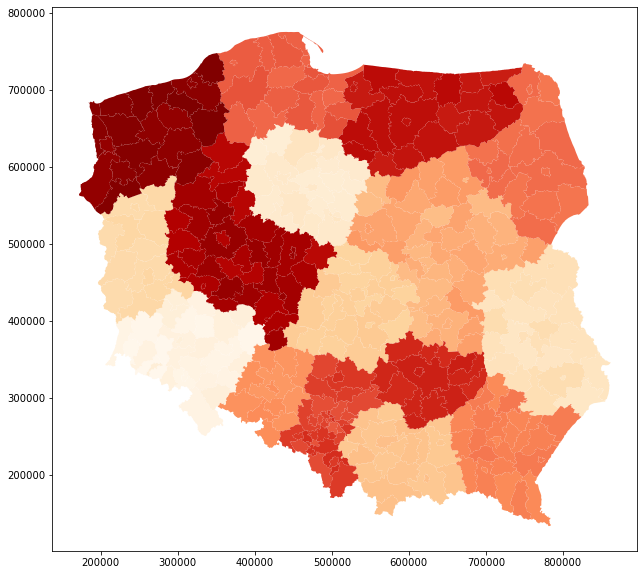

In [59]:
base = powiaty.plot(figsize=(15, 10), color='white', edgecolor='black');
cities.plot(ax=base, marker='o', color='red', markersize=5);

In [4]:
meteo_station.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ifcid       2651 non-null   int64   
 1   gmlid       2651 non-null   object  
 2   gmlidentif  2651 non-null   object  
 3   id_localid  2651 non-null   object  
 4   id_namespa  2651 non-null   object  
 5   name        2651 non-null   object  
 6   name1       2651 non-null   object  
 7   additional  2651 non-null   object  
 8   mediamonit  1204 non-null   object  
 9   mediamon_1  1447 non-null   object  
 10  responsibl  2651 non-null   object  
 11  mobile      2651 non-null   int64   
 12  activitype  2651 non-null   object  
 13  activity_1  831 non-null    object  
 14  geometry    2651 non-null   geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 310.8+ KB


In [49]:
s["dawn"].dtype

AttributeError: 'datetime.datetime' object has no attribute 'dtype'

In [50]:
type(s["dawn"])

datetime.datetime